# Healthcare on the Move: Patterns and Predictors of Medical Professional Migration in OECD Countries
**Elijah Adrian, Wuyang Ren, Pierre Lambelet, and Angelo Mladineo**

## Introduction

The Government of Canada states that health is an inalienable human right - crucial for sustainable development, economic prosperity, and poverty eradication - as well as being an indicator of a country's progress, as health increases the likelihood for sustained growth ([Global Affairs Canada](https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?lang=eng), 2017). It is through healthcare systems that governments directly affect the health of a nation. Therefore, it is imperative to study healthcare systems, find patterns among their characteristics, and evaluate their performance, in order to improve wellbeing for all citizens.

The purpose of this project is to analyze patterns in the migration of healthcare workers and health outcomes. This is an important field of study because while countries are capable of training their healthcare workers domestically, a substantial number come from outside their borders and contribute significantly to the healthcare labour force and thus health outcomes.
We will focus on OECD countries specifically, as their exists comprehensive datasets on them, from which patterns of migration and healthcare systems' performance can be observed.
For example, the latest OECD annual report on migration mentions that migration into OECD countries, in addition to employment of foreigners within them, reached record high levels in 2022 ([OECD](https://www.oecd.org/migration/international-migration-outlook-1999124x.htm), 2023). 

In order to explore the impact of medical professionals backgrounds', this research project is divided into three research sections of interest, with an additional section focused on maps showcasing visualizing the migration of medical professionals:

- The relationship between health outcomes and migration of healthcare providers 
- Government health insurance, per capita healthcare spending, and remuneration of medical professionals as predictive factors of healthcare professional migration
- Relationship between domestic and foreign-trained medical professionals
- Maps

## Data

### Importing libraries

As was mentioned in the introduction, the datasets in this project come from datasets found in [OECD data](https://data.oecd.org), but before we present and clean them, we start by importing the Python libraries that allow us to work with the data.

These are:
`math`, `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, and `statsmodels.api`.

We also have to load all the libraries necessary for the interactive map.

In [1]:
! pip install geopandas

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import geopandas as gpd
from bokeh.io import output_notebook,show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Label, Legend
from bokeh.palettes import brewer
output_notebook()
import json
from bokeh.palettes import OrRd

%matplotlib inline
sns.set()

Loading BokehJS ...

### Loading datasets

Now we read all the data files from the OECD. The naming convention we use is an abbreviation of the datasets' names (for example `demo_ref_raw` stands for **demo**graphic **ref**erence data and so on) and all of them have the suffix "raw" in their variable name to indicate that the datasets have not been processed.



In [2]:
demo_ref_raw = pd.read_csv('demographicref.csv') #demographic reference data
econ_ref_raw = pd.read_csv('econref.csv') #economic reference data
health_expen_raw = pd.read_csv('healthexpenditure.csv') #healthcare expenditure data
health_qual_raw = pd.read_csv('healthquality.csv') #healthcare quality data
health_resor_raw = pd.read_csv('healthresources.csv') #healthcare resources data
health_util_raw = pd.read_csv('healthutil.csv') #healthcare utilization data
social_proc_raw = pd.read_csv('socialprotection.csv') #social healthcare protection data
worker_migr_raw = pd.read_csv('healthworkmigration.csv') #healthcare worker migration data
health_stat_raw = pd.read_csv('healthstatus.csv',nrows = 284583) #health status data

Note that the final dataset (*healthstatus.csv*) cannot be loaded past the 284,614th line, so in order to avoid having partial data on one variable we needed to cut approximately the last 40,000 entries.

Each dataset we include was obtained from the following sources:
- [Demographic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR)  
- [Economic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR)  
- [Healthcare Expenditure Data](https://stats.oecd.org/Index.aspx?DataSetCode=SHA) 
- [Healthcare Quality Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI)  
- [Healthcare Resources Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC)  
- [Healthcare Utilization Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC)  
- [Social Healthcare Protection Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT)  
- [Healthcare Worker Migration Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI)  

Full citations are at the end of the document.

### Data cleaning

We start the data cleaning process by removing unwanted columns of data. We are left with columns that we deemed relevant for our project.

In [3]:
demo_ref_col = demo_ref_raw[['Variable','Measure','Country','Year','Value']]
econ_ref_col = econ_ref_raw[['Variable', 'Measure', 'Country','Year', 'Value']]
health_expen_col = health_expen_raw[['Financing scheme', 'Function','Provider', 'Measure', 'Country', 'Year', 'Unit', 'Value']]
health_qual_col = health_qual_raw[['Country','Periods','Indicator','Gender','Age Group','Value','Value.1']]
health_resor_col = health_resor_raw[['Variable','Measure','Country','Year','Value']]
health_util_col = health_util_raw[['Variable','Measure','Country','Year','Value']]
social_proc_col = social_proc_raw[['Variable','Measure','Country','Year','Value']]
worker_migr_col = worker_migr_raw[['Country','Variable','Country of origin','Year','Value']]
health_stat_col = health_stat_raw[['Variable','Measure','Country','Year','Value']]

We proceed to remove unwanted rows of data. Typically, these are rows containing data measured in units that cannot be compared between countries (e.g. in local currency or raw numbers of incidents). In addition to that, we have to remove rows containing variables with few observations or rows that are unlikely to be helpful for our purposes. Almost all data sets required this, the exceptions are `demo_ref_col` and `worker_mig_col`.

In [4]:
econ_ref_clean = econ_ref_col.loc[(econ_ref_col['Measure']=='National currency unit per US$, PPP')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')|
                       (econ_ref_col['Measure']=='Million US$ at exchange rate')|
                       (econ_ref_col['Measure']=='/capita, US$ exchange rate ')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')]

health_expen_clean = health_expen_col.loc[(health_expen_col['Measure']=='Share of gross domestic product')|
                       (health_expen_col['Measure']=='Constant prices, OECD base year')|
                       (health_expen_col['Measure']=='Share of current expenditure on health')|
                       (health_expen_col['Measure']=='Per capita, current prices, current PPPs')]

health_qual_clean = health_qual_col.loc[((health_qual_col['Value']=='Age-sex standardised rate per 100 000 population')|
               (health_qual_col['Value']=='Age-sex standardised rate per 100 patients')|
               (health_qual_col['Value']=='Age-standardised survival (%)'))|
               (health_qual_col['Value']=='Rate per 100 deaths (%)')|
               (health_qual_col['Value']=='Crude rate per 100 patients')|
               (health_qual_col['Value']=='Age-sex standardised ratio')|
               (health_qual_col['Value']=='Age-standardised survival (%)')|
               (health_qual_col['Value']=='Ratio')|
               (health_qual_col['Gender']=='Total')] 

health_qual_clean = health_qual_clean.drop(list((health_qual_clean.loc[(health_qual_clean['Periods']=="2000-2004")|
                                                                      (health_qual_clean['Periods']=="2005-2009")|
                                                                      (health_qual_clean['Periods']=="2010-2014")|
                                                                      (health_qual_clean['Periods']=="2015-2019")]).index.values)) 

health_resor_clean = health_resor_col.loc[(health_resor_col['Measure']=='Density per 1 000 population (head counts)')|
                (health_resor_col['Measure']=='Per million population')|
                (health_resor_col['Measure']=='% of total physicians (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 population')|
                (health_resor_col['Measure']=='% of physicians (head counts)')|
                (health_resor_col['Measure']=='Per 100 000 population')|
                (health_resor_col['Measure']=='% of total hospital employment (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 live births')|
                (health_resor_col['Measure']=='Salaried, income, US$ exchange rate')] 

health_util_clean = health_util_col.loc[(health_util_col['Measure']=='Per 100 000 population')|
               (health_util_col['Measure']=='% performed as inpatient cases')|
               (health_util_col['Measure']=='% performed as day cases')|
               (health_util_col['Measure']=='Per 100 000 females')|
               (health_util_col['Measure']=='Inpatient cases per 100 000 population ')|
               (health_util_col['Measure']=='Total procedures per 100 000 population')|
               (health_util_col['Measure']=='Day cases per 100 000 population')|
               (health_util_col['Measure']=='Per 1 000 population')|
               (health_util_col['Measure']=='% of children immunised')|
               (health_util_col['Measure']=='Waiting times from specialist assessment to treatment: Mean (days)')|
               (health_util_col['Measure']=='Waiting times of patients on the list: % of all patients waiting more than 3 months')|
               (health_util_col['Measure']=='Waiting times of patients on the list: Mean (days)')]

social_proc_clean = social_proc_col.loc[(social_proc_col['Measure']=='% of total population')|
                                        (social_proc_col['Measure']=='% of total population covered')] 

health_stat_clean = health_stat_col.loc[(health_stat_col['Measure']=='Deaths per 100 000 females (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 females (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 females, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 males, aged 75 years old')|
               (health_stat_col['Measure']=='Years lost, /100 000 population, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (crude rates)')|
               (health_stat_col['Measure']=='% of population (crude rate)')|
               (health_stat_col['Measure']=='Years')|
               (health_stat_col['Measure']=='Incidence per 100 000 population')|
               (health_stat_col['Measure']=='Deaths per 1 000 live births')]

Next we want to remove all the countries not present in the migration dataframe (`worker_migr_col`) from every other dataframe. We specifically select countries with a sufficient number of observations (50 observations was deemed appropriate). To do this we use a for loop that appends an empty list with countries if they have sufficient migration data and are not in the list already (to avoid for repeated entries). 

This results in the `migr_list` list, where we have all the countries (i.e. country names) that meet our observations criteria without duplicates.

In [5]:
migr_list = []
for country in worker_migr_col["Country"]:
    if (worker_migr_col["Country"].value_counts()[country] > 50) and (country not in migr_list):
        migr_list.append(country)

We put `migr_list` into action immediately by filtering for all the rows in each dataframe where the *"Country"* column's value is in the list.

In [6]:
econ_ref_clean = econ_ref_clean.loc[(econ_ref_clean["Country"].isin(migr_list))]
demo_ref_clean = demo_ref_col.loc[(demo_ref_col["Country"].isin(migr_list))]
health_expen_clean = health_expen_clean.loc[(health_expen_clean["Country"].isin(migr_list))]
health_qual_clean = health_qual_clean.loc[(health_qual_clean["Country"].isin(migr_list))]
health_resor_clean = health_resor_clean.loc[(health_resor_clean["Country"].isin(migr_list))]
health_util_clean = health_util_clean.loc[(health_util_clean["Country"].isin(migr_list))]
social_proc_clean = social_proc_clean.loc[(social_proc_clean["Country"].isin(migr_list))]
health_stat_clean = health_stat_clean.loc[(health_stat_clean["Country"].isin(migr_list))]

Lastly before pivoting we want to reset all the indexes.

In [7]:
econ_ref_clean = econ_ref_clean.reset_index()
demo_ref_clean = demo_ref_clean.reset_index()
health_expen_clean = health_expen_clean.reset_index()
health_qual_clean = health_qual_clean.reset_index()
health_resor_clean = health_resor_clean.reset_index()
health_util_clean = health_util_clean.reset_index()
social_proc_clean = social_proc_clean.reset_index()
health_stat_clean = health_stat_clean.reset_index()

It is important to note that the dataframes in the code cell above have the suffix *"clean"*, this is to indicate that they have been processed (i.e. cleaned) and are ready for statistical analysis. We started using this naming convention before, and while these versions of the dataframes are not the ones we would present (a more suitable display is in the next code cell), it is from these versions where most of our work will stem. 

Next we have to pivot each dataframe, and merge the reference data, i.e. data that is not directly related to healthcare but that describes the countries we are going to use (such as purchasing power for `econ_ref` and employment for `demo_ref`).

In [8]:
worker_migr = worker_migr_col.pivot_table(index = ['Year','Country'], columns = ['Variable'], values = 'Value')
demo_ref = demo_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
econ_ref = econ_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_expen = health_expen_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Function'], values = 'Value')
health_qual = health_qual_clean.pivot_table(index = ['Periods','Country','Age Group'], columns = ['Value','Indicator'], values = 'Value.1')
health_resor = health_resor_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_util = health_util_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
social_proc = social_proc_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_stat = health_stat_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')

reference = pd.merge(demo_ref,econ_ref, on = ['Year','Country'])

In [9]:
worker_migr

Variable          % of foreign-trained doctors  % of foreign-trained nurses  \
Year Country                                                                  
2010 Austria                             3.900                          NaN   
     Belgium                             8.200                         1.46   
     Canada                             23.197                         7.22   
     Costa Rica                            NaN                          NaN   
     Czechia                             4.400                          NaN   
...                                        ...                          ...   
2022 Lithuania                           0.720                         0.45   
     New Zealand                        42.150                        31.16   
     Slovenia                           15.400                          NaN   
     Spain                                 NaN                          NaN   
     Switzerland                           NaN                          NaN   

Variable          Domestically-trained doctors  Domestically-trained nurses  \
Year Country                                                                  
2010 Austria                           31753.0                          NaN   
     Belgium                           49038.0                     163140.0   
     Canada                            62059.0                     327399.0   
     Costa Rica                            NaN                          NaN   
     Czechia                           40740.0                          NaN   
...                                        ...                          ...   
2022 Lithuania                         13866.0                      24690.0   
     New Zealand                       10849.0                      40109.0   
     Slovenia                           6005.0                          NaN   
     Spain                                 NaN                          NaN   
     Switzerland                           NaN                          NaN   

Variable          Foreign-trained doctors - Annual inflow  \
Year Country                                                
2010 Austria                                        191.0   
     Belgium                                        504.0   
     Canada                                        2437.0   
     Costa Rica                                      15.0   
     Czechia                                        103.0   
...                                                   ...   
2022 Lithuania                                       30.0   
     New Zealand                                    663.0   
     Slovenia                                        45.0   
     Spain                                         4969.0   
     Switzerland                                   2178.0   

Variable          Foreign-trained doctors - Stock  \
Year Country                                        
2010 Austria                               1289.0   
     Belgium                               4380.0   
     Canada                               18765.0   
     Costa Rica                               NaN   
     Czechia                               1874.0   
...                                           ...   
2022 Lithuania                              102.0   
     New Zealand                           7904.0   
     Slovenia                              1093.0   
     Spain                                    NaN   
     Switzerland                              NaN   

Variable          Foreign-trained nurses - Annual inflow  \
Year Country                                               
2010 Austria                                         NaN   
     Belgium                                       361.0   
     Canada                                       2333.0   
     Costa Rica                                      6.0   
     Czechia                                         NaN   
...                                     

Here we have the final versions of our dataframes. We have eight dataframes that display data regarding healthcare, and one dataframe (the `reference` dataframe) that describes countries' economic and demographic conditions.

Most dataframes have the same hierarchical index, where we have 'Year' and 'Country' as the two indices. `health_qual` is the exception, as it uses three indices, but all dataframes follow an initial index regarding time measurements, followed by a location ("Country") index.

## Healthcare Quality and Health Status as Predictive Factors of Healthcare Professional Migration
 

We hypothesize that countries with poorer healthcare outcomes and perceived health status tend to have a higher number of immigrant healthcare professionals. The rationale is the assumption that governments of these nations might be incentivized to bolster healthcare capabilities by facilitating the immigration of healthcare workers to improve overall health metrics.

Our project evaluates healthcare quality and health status from three distinct perspectives:

1. **Quality of Acute Care**: We assess this through the mortality rates and hospital readmission rates for critical conditions, including:
* Acute Myocardial Infarction (AMI, commonly known as a heart attack)
* Haemorrhagic stroke
* Ischemic stroke
* Hip fractures with surgeries initiated within two calendar days of hospital admission.
2. **Patient Experience:** This aspect is gauged through responses to questionnaires, focusing on the percentage of patient having enough consultation time
3. **Perceived Health Status**: We measure this through the percentage of the population that perceives their health as poor.
4. **Age**: Percentage of the population over 65. This is an important aspect of a country's overall health status, as the senuior population tend to require more health services

Through these measures, we aim to investigate how healthcare quality and health status could predict the migration of healthcare professionals.

In [10]:
mor_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 patients"
hos_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 000 population" #Measure of mortality rate and hospital admission/readmission rate
doc_val = health_qual_clean["Value"] == "Crude rate per 100 patients"
doc_gender = health_qual_clean["Gender"] == "Total"

health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])
yrs =  health_qual_clean["Periods"] > 2014

mor_ind = health_qual_clean["Indicator"].str.contains("mortality")
re_hos_ind = health_qual_clean["Indicator"].str.contains("hospital readmission")
doc_val_ind = health_qual_clean["Indicator"].str.contains("spending enough time with patients during the consultation")

qual_mor = health_qual_clean[mor_ind & yrs & mor_val]
qual_re_hos = health_qual_clean[re_hos_ind & yrs & hos_val]
qual_doc= health_qual_clean[doc_val_ind & yrs & doc_val & doc_gender ]


mor_countries = set(qual_mor['Country'].unique())
re_hos_countries = set(qual_re_hos['Country'].unique())
doc_countries = set(qual_doc['Country'].unique())

common_countries = mor_countries & re_hos_countries & doc_countries #filtering out countries

qual_mor_filtered = qual_mor[qual_mor['Country'].isin(common_countries)]
qual_re_hos_filtered = qual_re_hos[qual_re_hos['Country'].isin(common_countries)]
qual_doc_filtered = qual_doc[qual_doc['Country'].isin(common_countries)]

With our filtered data, we create new, small "summary" dataframes that allow for a clear plotting of average mortality and average hospital readmission rates since the year 2015.

In [11]:
summary_qual_mor = pd.DataFrame(qual_mor_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Mortality'})
summary_qual_re_hos = pd.DataFrame(qual_re_hos_filtered .groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Readmission'})
summary_qual_doc =  pd.DataFrame(qual_doc_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Enough Consultation Time'})

We do the same to represent countries with "bad health", using the crude rate as a first filter (in this context, crude rate is a measurement of health quality spanning from "very good" to "very bad"), and then filtering specifically for "bad/very bad health" such that we can focus on the proportion of people that are perceived to have bad health conditions. 

In [12]:
bad_health = pd.DataFrame(health_stat["% of population (crude rate)"]["Bad/very bad health, total aged 15+"]).rename(columns={'Bad/very bad health, total aged 15+': 'Bad Health'})
bad_health = bad_health[bad_health.index.get_level_values('Year') > 2014]
bad_health_filterd = bad_health[bad_health.index.get_level_values('Country').isin(common_countries)]

summary_bad_health = pd.DataFrame(bad_health_filterd.groupby(['Country'])['Bad Health'].mean()) 

We also need to consider the population age distribution of countries as it may be a factor that influences the perceived health of the nation, and in turn how effective a healthcare system is. 

In [13]:
age_ref = pd.DataFrame(reference["% of total population"]["Population: 65 years old and over"])
age_ref = age_ref[age_ref.index.get_level_values('Year') > 2014]
age_ref_filtered = age_ref[age_ref.index.get_level_values('Country').isin(common_countries)]

age_summary = pd.DataFrame(age_ref_filtered.groupby("Country").mean())

To account for the age distribution, the process is similar to `summary_bad_health`, where we first extract values from the `reference`, specifically, the *"Population: 65 years old and over"* column that is within the *"% of total population"* column set. Second, we filter for all values starting in 2015, and index them by year. Third, we filter for countries are in our `common_countries` list. Finally, we create a plot-friendly data frame called `age_summary` where we take the mean of each of the countries' entries to have an average percentage of the population that is 65 years old and over.


We proceed to plot mortality rates, hospital readmission rates, percentages of the population with bad health conditions and percentage of patients with enough consultation time among our common countries.

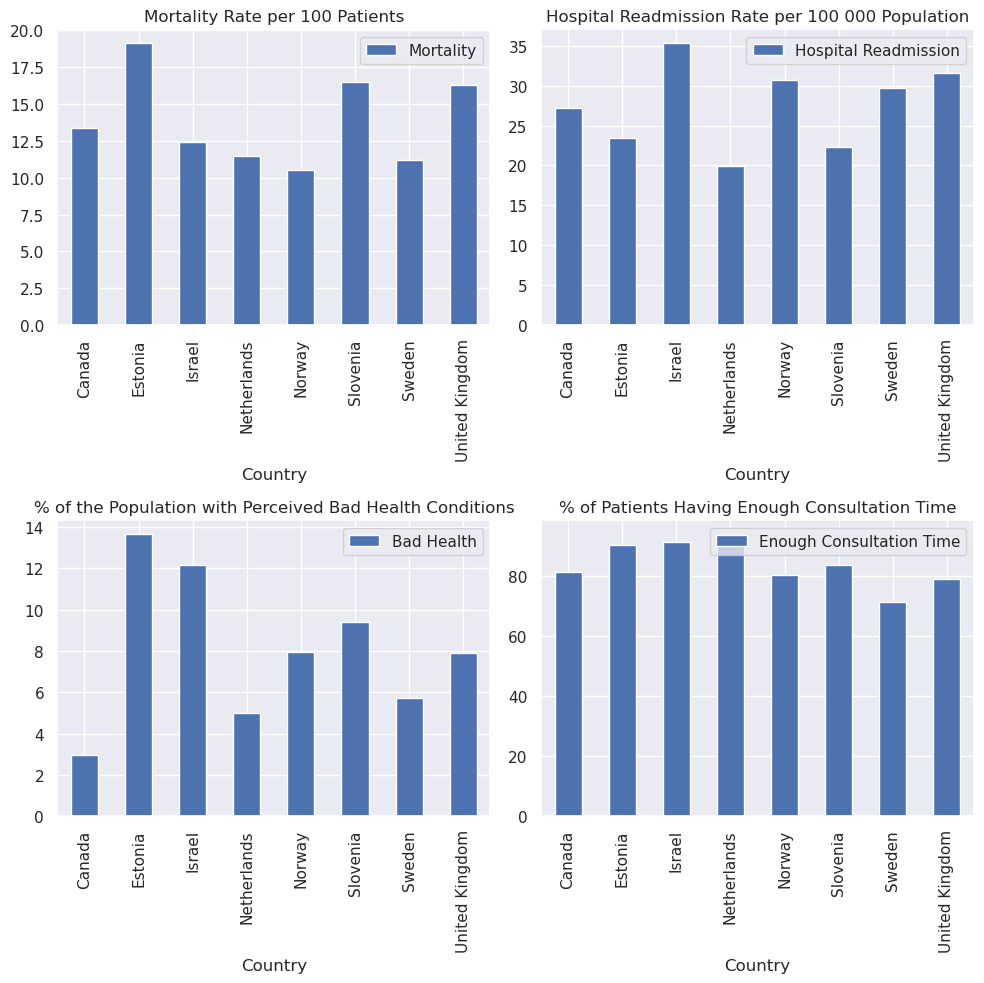

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0] = summary_qual_mor.plot.bar(ax=ax[0,0])
ax[0, 0].set_title("Mortality Rate per 100 Patients")
ax[0, 1] = summary_qual_re_hos.plot.bar(ax=ax[0, 1])
ax[0, 1].set_title("Hospital Readmission Rate per 100 000 Population")
ax[1, 0] = summary_bad_health.plot.bar(ax=ax[1,0])
ax[1, 0].set_title("% of the Population with Perceived Bad Health Conditions")
ax[1, 1] = summary_qual_doc.plot.bar(ax = ax[1,1])
ax[1, 1].set_title("% of Patients Having Enough Consultation Time")
plt.tight_layout()

From the graphs we can start visualizing the distinction between health quality and patient satisfaction, as mortality rates and hospital readmission rates inform us about the former, while the perceived population health and the percentage of patients with enough consultation time tell us about the latter. 

More importantly, at this point we have different measures for health systems effectiveness across different countries through different metrics, thus, we can start look for the relationship proportions of foreign workers might have with the metrics we plotted.

### Health Workforce Migration

Similarly to how we filtered out health quality statistics, we now refer to the `worker_migr` data frame so that we can access values of the inflow of foreign-trained doctors per year column, filtering for values since 2015 and for our `common_countries`.

Text(0.5, 1.0, 'Foreign-Trained Doctors Annual Inflow')

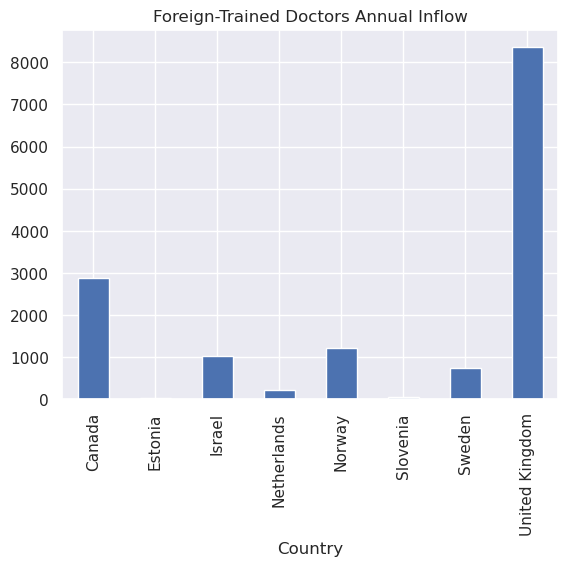

In [15]:
worker_migr_filtered = worker_migr[["Foreign-trained doctors - Annual inflow"]][worker_migr.index.get_level_values('Year') > 2014]
worker_migr_summary = worker_migr_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow'].mean().fillna(0)
worker_migr_summary = worker_migr_summary[worker_migr_summary.index.get_level_values('Country').isin(common_countries)]
fig, ax = plt.subplots()
ax = worker_migr_summary.plot.bar()
ax.set_title("Foreign-Trained Doctors Annual Inflow")


From the plot we observe the average yearly inflow of doctors for each country, where the United Kingdom outpaces every other country by a large margin. 

In addition to the five characteristics of health care we are analyzing and controlling (mortality and hospital readmission rates, percentages of perceived population with bad health and of patients with enough consultation time, in addition to controlling for the proportion of the population 65 years old and over), we include GDP per capita measured in USD purchasing power parity to account for the possibility that the wealth of a nation not only influences how much investment does a healthcare system have, but it also incentivizes foreign doctors to work at said nations with more resources devoted to their area of expertise. 

We continue filtering the reference data frame so that we can form a dataframe called `imm_qual` (**imm**igrant doctors' impact on health **qual**ity) where all the characteristics from our countries of interest are merged with the average inflow of foreign doctors is included, such that we can investigate whether there is a relationship among the data.

In [17]:
imm_qual = pd.merge(summary_qual_mor, summary_qual_re_hos, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_qual_doc, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_bad_health, on = ['Country'])
imm_qual = pd.merge(imm_qual, worker_migr_summary, on = ['Country']) 
imm_qual = pd.merge(imm_qual, age_summary, on = ['Country']) 

We utilize our new data frame to plot a correlation matrix so that we can test if there is a link among the characteristics we are exploring.

In [18]:
imm_correlation_matrix = imm_qual.corr()

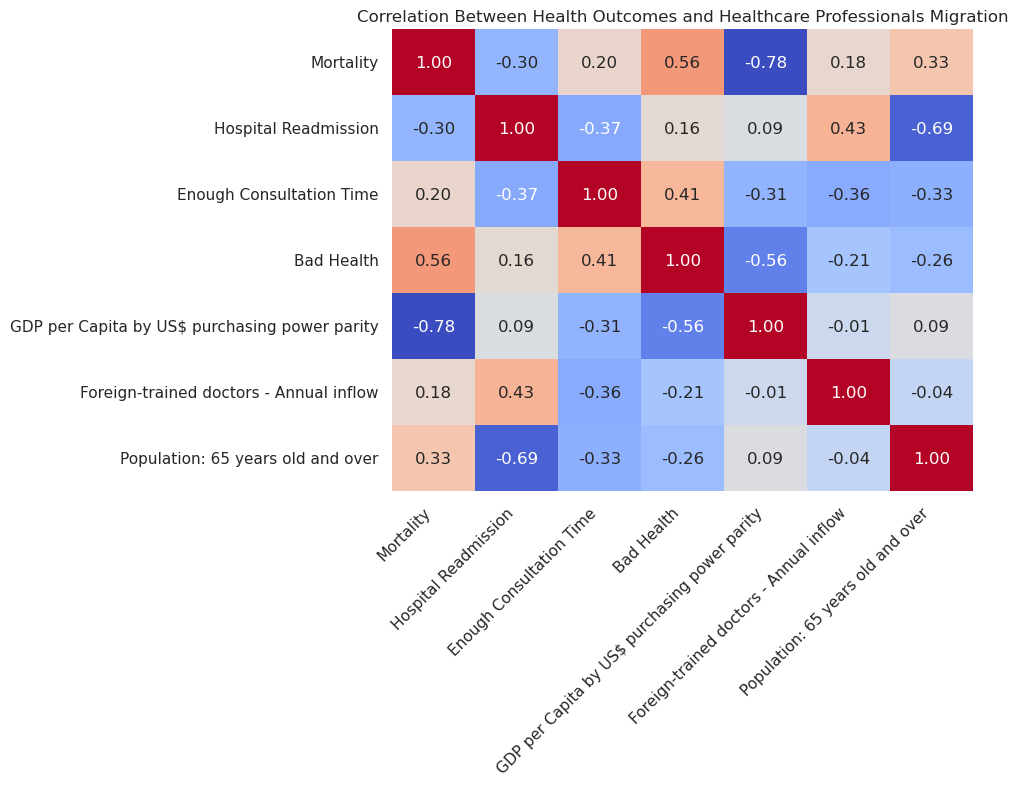

In [19]:
plt.figure(figsize=(7.5, 6))  
sns.heatmap(imm_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Between Health Outcomes and Healthcare Professionals Migration')

plt.show()

Emphasizing on the "Foreign-trained doctors - Annual inflow" variable, there is a slight, positive correlation among mortality rates and flow of foreign doctors, meanwhile there is a considerably higher positive correlation between hospital readmission rates and foreign-doctors annual inflow. This implies that quality of acute healthcare tends to be worse as the annual inflow of foreign-trained doctors increases. 

In terms of the perceived effect of the healthcare system, there is a negative correlation for both percentage of the population with perceived bad health and the percentage of the patients that are reported to have enough consultation time. In addition to that, there is a correlation of -0.01 between GDP per capita and inflow of foreign doctors, hence it is negligible among all the other values regarding foreign doctors.

To check if the correlations found above are good indicators of the effect of foreign doctors in healthcare quality, we used an OLS regression, where we regress Mortality rates, Hospital Readmission rates, Sufficient Consultation Time percentage, and Perceived Bad Health percentage on Foreign-trained doctors.

In [20]:
imm_qual

,Mortality,Hospital Readmission,Enough Consultation Time,Bad Health,GDP per Capita by US$ purchasing power parity,Foreign-trained doctors - Annual inflow,Population: 65 years old and over
Country,,,,,,,
Canada,13.355556,27.222222,81.150000,2.957143,49574.8750,2884.571429,17.200000
Estonia,19.109524,23.452778,90.100000,13.650000,37545.9875,17.875000,19.625000
Israel,12.407143,35.295238,91.116667,12.157143,41010.8375,1022.500000,11.657143
Netherlands,11.462698,19.883333,93.742857,4.987500,58788.9750,212.285714,18.925000
Norway,10.547619,30.756667,80.200000,7.933333,70919.6875,1213.142857,17.087500
Slovenia,16.499206,22.327778,83.433333,9.412500,39840.6750,58.750000,19.537500
Sweden,11.167460,29.723810,71.350000,5.725000,55387.4625,748.333333,19.812500
United Kingdom,16.284259,31.597917,78.800000,7.920000,47589.0625,8362.714286,18.314286


In [21]:
from sklearn import linear_model

X = imm_qual[["Mortality", "Enough Consultation Time", "Bad Health", "Hospital Readmission"]]
y = imm_qual['Foreign-trained doctors - Annual inflow'] 

X = sm.add_constant(X)
doc_imm_model = sm.OLS(y, X)
doc_imm_result = doc_imm_model.fit()

print(doc_imm_result.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Foreign-trained doctors - Annual inflow   R-squared:                       0.728
Model:                                                 OLS   Adj. R-squared:                  0.364
Method:                                      Least Squares   F-statistic:                     2.002
Date:                                     Sun, 21 Apr 2024   Prob (F-statistic):              0.297
Time:                                             00:57:23   Log-Likelihood:                -69.127
No. Observations:                                        8   AIC:                             148.3
Df Residuals:                                            3   BIC:                             148.7
Df Model:                                                4                                         
Covariance Type:                                 nonrobust                                         


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The OLS gives us a similar but not identical relationship between the independent variables and the annual inflow of foreign doctors in comparison to just using correlations. 

The first thing to notice is that the adjusted $R^2$ is 0.364, implying that our model has some explanation power. However, every coefficient has a p-value greater than 0.10, meaning that we cannot rely on them, even on a 90% level of confidence.

Because our regression has a noticeable $R^2$ but statistically insignificant coefficients, we must use different methods to check if they can be relied upon, which is why we went with a lasso regression to test for their explanatory strength.

For now, what we can interpret from the regression is that because our acute health quality indicators (Mortality and Hospital readmission) both have positive coefficients, in worse health quality conditions (higher mortality rates and higher readmission rates) we have greater inflows of foreign-doctors. 
The indicators of how efficiently patients are treated and how they perceive their health tell a different story. Because "Bad Health" has a negative coefficient and "Enough Consultation Time" has a positive one, our model predicts that the greater the proportion of patients with enough consultation time, the greater the inflow of foreign doctors. Additionally, the smaller the fraction of the population with perceived bad health, the inflow of foreign doctors is also larger according to the model.

In [22]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)
lr_coefs = pd.Series(dict(zip(list(X),lr_model.coef_)))
lasso_coefs_dict = {}
for alpha in [1, 5, 10, 15]:
    lasso_model = linear_model.Lasso(alpha)
    lasso_model.fit(X, y)
    lasso_coefs_dict[f'alpha = {alpha}'] = pd.Series(lasso_model.coef_, index = list(X))
    
coefs_comparison = pd.DataFrame(lasso_coefs_dict)
coefs_comparison

,alpha = 1,alpha = 5,alpha = 10,alpha = 15
const,0.000000,0.000000,0.000000,0.000000
Mortality,897.040078,894.866295,892.147283,889.442821
Enough Consultation Time,78.795806,78.169883,77.386813,76.609180
Bad Health,-773.667189,-771.484639,-768.754746,-766.038778
Hospital Readmission,513.970142,512.855664,511.461717,510.074705


After running the Lasso regression, the coefficients do not shrink significantly with various levels of alpha, indicating that all regressors have strong predictive power.

### Results
In countries where the quality of acute healthcare is lower, as evidenced by higher mortality and hospital readmission rates, there is a tendency to have a higher proportion of immigrant doctors in the medical workforce. On the other hand, countries that report better patient satisfaction and overall health status are associated with a greater presence of immigrant doctors.

## Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration

This section investigates the predictive power and effects of government insurance, healthcare spending per capita, and healthcare professional remuneration on the migration of foreign healthcare professionals. While economic theory suggests a positive relationship between remuneration and migration, as healthcare workers seek better pay, it is unclear how government insurance will come into play. It is likely that high healthcare spending is related to high healthcare professional remuneration, so the relationships should be similar. As this is a purely predictive analysis, we are not concerned with multicollinearity. 

For this analysis it was necessary to remove the GP remuneration data due to a low number of observations, so we will use specialist remuneration as a proxy for overall physician salary. The relationship, when plotted between healthcare spending and the dependent variables of interest, suggested nonlinearity, so the logarithm was taken. The data on doctor and nurse inflow was highly skewed, but taking the log also resolved this. Since the data is over several years, we take the average of the data for each country to account for outlier years and prevent autocorrelation.

In [23]:
log_hlth_percap_ppp = np.log(health_expen["Per capita, current prices, current PPPs"]["Current expenditure on health (all functions)"])
nur_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of specialists"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
log_for_doc_inf = np.log(worker_migr.loc[worker_migr["Foreign-trained doctors - Annual inflow"]!=0]["Foreign-trained doctors - Annual inflow"])
log_for_nur_inf = np.log(worker_migr.loc[worker_migr["Foreign-trained nurses - Annual inflow"]!=0]["Foreign-trained nurses - Annual inflow"])

In [24]:
hlth_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Current expenditure on health (all functions)"]
nur_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of specialists"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
for_doc_inf = worker_migr["Foreign-trained doctors - Annual inflow"]
for_nur_inf = worker_migr["Foreign-trained nurses - Annual inflow"]

In [25]:
in_hc_rem = pd.concat([hlth_percap_ppp,spec_sal_usd,nur_sal_usd,gov_hi_pct,for_doc_pct,for_doc_inf,for_nur_pct,for_nur_inf],axis=1)
in_hc_rem = in_hc_rem.groupby('Country').mean()
in_hc_rem["Current expenditure on health (all functions)"] = np.log(in_hc_rem["Current expenditure on health (all functions)"])
in_hc_rem["Foreign-trained doctors - Annual inflow"] = np.log(in_hc_rem["Foreign-trained doctors - Annual inflow"])
in_hc_rem["Foreign-trained nurses - Annual inflow"] = np.log(in_hc_rem["Foreign-trained nurses - Annual inflow"])
in_hc_rem = in_hc_rem.rename(columns = {"Current expenditure on health (all functions)":"log(Per capita current expenditure on health (PPP))",
                                       "Foreign-trained doctors - Annual inflow":"log(Foreign-trained doctors - Annual inflow)",
                                       "Foreign-trained nurses - Annual inflow":"log(Foreign-trained nurses - Annual inflow)"})

After combining all the data, we now have `in_hc_rem` which contains, for each country, the remuneration of healthcare professionals, expenditure on healthcare, percentage of the population covered by government health insurance, percent of healthcare professionals that are from other countries, and inflow of healthcare professionals.

In [26]:
doc_inf_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of specialists",
                          "Government/compulsory health insurance coverage","log(Foreign-trained doctors - Annual inflow)"]].dropna()

doc_pct_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of specialists",
                          "Government/compulsory health insurance coverage","% of foreign-trained doctors"]].dropna()

nur_inf_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of hospital nurses",
                          "Government/compulsory health insurance coverage","log(Foreign-trained nurses - Annual inflow)"]].dropna()

nur_pct_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of hospital nurses",
                          "Government/compulsory health insurance coverage","% of foreign-trained nurses"]].dropna()

### Correlations Between all Factors

We begin with a correlation matrix, as it provides a starting point for the links we may observe among foreign-trained health workers and expenditure.

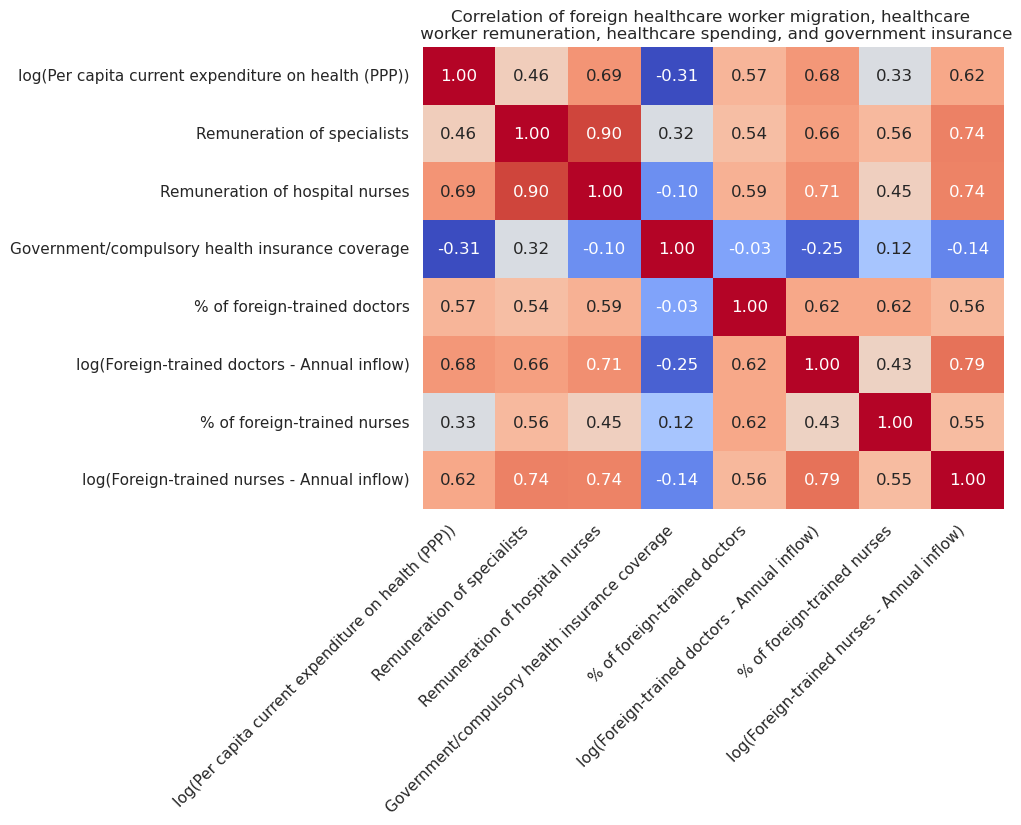

In [27]:
in_hc_rem_corr  = in_hc_rem.corr()

plt.figure(figsize=(7.5, 6))  
sns.heatmap(in_hc_rem_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation of foreign healthcare worker migration, healthcare \n worker remuneration, healthcare spending, and government insurance')

plt.show()

All factors are positively correlated with each other, except for government insurance coverage which is negatively correlated with most other factors. The correlations for remuneration of both doctors and nurses are consistent with economic theory. 

### Predictive Models

Predictive regressions of migration based on government insurance, healthcare spending, and remuneration.

In [28]:
x_docinf = doc_inf_pred.loc[:,~doc_inf_pred.columns.isin(["log(Foreign-trained doctors - Annual inflow)"])]
y_docinf = doc_inf_pred["log(Foreign-trained doctors - Annual inflow)"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docinf_model.fit()

print(x_docinf_result.summary())

                                         OLS Regression Results                                         
Dep. Variable:     log(Foreign-trained doctors - Annual inflow)   R-squared:                       0.598
Model:                                                      OLS   Adj. R-squared:                  0.535
Method:                                           Least Squares   F-statistic:                     9.436
Date:                                          Sun, 21 Apr 2024   Prob (F-statistic):           0.000497
Time:                                                  00:57:24   Log-Likelihood:                -37.461
No. Observations:                                            23   AIC:                             82.92
Df Residuals:                                                19   BIC:                             87.46
Df Model:                                                     3                                         
Covariance Type:                                      n

**Interpretation**

A 1% increase in per capita health spending gives a 1.65% increase in foreign doctor inflow, a $1000 increase in specialist remuneration gives a 1.78% increase in foreign doctor inflow, and an increase in government healthcare coverage of 1 percentile point gives a 7.09% decrease in foreign doctor inflow.

In [29]:
x_docpct = doc_pct_pred.loc[:,~doc_pct_pred.columns.isin(["% of foreign-trained doctors"])]
y_docpct = doc_pct_pred["% of foreign-trained doctors"]

x_docpct = sm.add_constant(x_docpct)
x_docpct_model = sm.OLS(y_docpct, x_docpct)
x_docpct_result = x_docpct_model.fit()

print(x_docpct_result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     % of foreign-trained doctors   R-squared:                       0.424
Model:                                      OLS   Adj. R-squared:                  0.328
Method:                           Least Squares   F-statistic:                     4.417
Date:                          Sun, 21 Apr 2024   Prob (F-statistic):             0.0170
Time:                                  00:57:24   Log-Likelihood:                -85.873
No. Observations:                            22   AIC:                             179.7
Df Residuals:                                18   BIC:                             184.1
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025   

**Interpretation**

A 1% increase in per capita health spending gives a 0.13 percentile point increase in foreign doctor percentage, a $1000 increase in specialist remuneration gives a 0.10 percentile point increase in foreign doctor percentage, and an increase in government healthcare coverage of 1 percentile point gives a 0.14 percentile point decrease in foreign doctor percentage.

In [30]:
x_nurinf = nur_inf_pred.loc[:,~nur_inf_pred.columns.isin(["log(Foreign-trained nurses - Annual inflow)"])]
y_nurinf = nur_inf_pred["log(Foreign-trained nurses - Annual inflow)"]

x_nurinf = sm.add_constant(x_nurinf)
x_nurinf_model = sm.OLS(y_nurinf, x_nurinf)
x_nurinf_result = x_nurinf_model.fit()

print(x_nurinf_result.summary())

                                         OLS Regression Results                                        
Dep. Variable:     log(Foreign-trained nurses - Annual inflow)   R-squared:                       0.571
Model:                                                     OLS   Adj. R-squared:                  0.510
Method:                                          Least Squares   F-statistic:                     9.327
Date:                                         Sun, 21 Apr 2024   Prob (F-statistic):           0.000406
Time:                                                 00:57:24   Log-Likelihood:                -46.551
No. Observations:                                           25   AIC:                             101.1
Df Residuals:                                               21   BIC:                             106.0
Df Model:                                                    3                                         
Covariance Type:                                     nonrobust  

**Interpretation**

A 1% increase in per capita health spending gives a 0.78% increase in foreign nurse inflow, a $1000 increase in hospital nurse remuneration gives a 6.28% increase in foreign nurse inflow, and an increase in government healthcare coverage of 1 percentile point gives a 0.66% decrease in foreign nurse inflow.

In [31]:
x_nurpct = nur_pct_pred.loc[:,~nur_pct_pred.columns.isin(["% of foreign-trained nurses"])]
y_nurpct = nur_pct_pred["% of foreign-trained nurses"]

x_nurpct = sm.add_constant(x_nurpct)
x_nurpct_model = sm.OLS(y_nurpct, x_nurpct)
x_nurpct_result = x_nurpct_model.fit()

print(x_nurpct_result.summary())

                                 OLS Regression Results                                
Dep. Variable:     % of foreign-trained nurses   R-squared:                       0.228
Model:                                     OLS   Adj. R-squared:                  0.122
Method:                          Least Squares   F-statistic:                     2.161
Date:                         Sun, 21 Apr 2024   Prob (F-statistic):              0.121
Time:                                 00:57:24   Log-Likelihood:                -94.907
No. Observations:                           26   AIC:                             197.8
Df Residuals:                               22   BIC:                             202.8
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]


**Interpretation**

A 1% increase in per capita health spending gives a 0.02 percentile point increase in foreign nurse percentage, a $1000 increase in hospital nurse remuneration gives a 0.20 percentile point increase in foreign nurse percentage, and an increase in government healthcare coverage of 1 percentile point gives a 0.14 percentile point increase in foreign nurse percentage.

### Results
In our four OLS regressions we observe positive relationships among both the annual inflow of foreign trained health professionals (doctors and nurses) and the proportion of foreign health workers percentage with respect to per capita health spending. These are consistent with the expectation that greater healthcare funding per capita attracts foreign workers. It is important to note, however, that two of these coefficients (in our regressions with respect to nurse inflow and percentage of foreign nurses) have large p-values (0.416 and 0.743 respectively).

As well, the relationship between remuneration and the migration behavior of foreign trained medical workers is positive. Three out of the four coefficients are statistically significant (remuneration of hospital nurses in the percentage of foreign-trained nurses is the exception with a p-value of 0.157). Again matching the expectations from economic theory.

Finally, government insurance coverage has a negative relationship with respect to foreign-trained healthcare professionals, but none of the coefficients for it are significant among the four regressions. This is likely due to the low degree of variation in government health coverage for OECD countries.

## Relationship Between Domestic and Foreign-Trained Medical Professionals

While we have mentioned the proportions of local and foreign healthcare professionals before, being able to visualize each country's distribution provides a reference point about the magnitudes, i.e. visualizing if foreign-trained healthcare professionals account for 10% of the industry or 40% of the industry.

To do this we use the `worker_migr` dataframe to obtain data suitable for plotting and created `worker_migr_to_plot`, where we calculated and filtered for values regarding the proportion of domestically-trained healthcare workers and the proportion of foreign-trained healthcare workers.

In [32]:
#create new column for percentage of domestically trained healthcare workers
#sum domestic trained doctors and nurses, divide by total
worker_migr['%_of_domestic_trained_healthcare_workers'] = (
    (worker_migr['Domestically-trained doctors'] + worker_migr['Domestically-trained nurses']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])) * 100

worker_migr['%_of_foreign_trained_healthcare_workers'] = (
    (worker_migr['Foreign-trained doctors - Stock'] + worker_migr['Foreign-trained nurses - Stock']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])) * 100

worker_migr = worker_migr.reset_index()

In [33]:
worker_migr_to_plot = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                                    '%_of_foreign_trained_healthcare_workers']].groupby('Country').mean().dropna().reset_index()

worker_migr_to_plot.head()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers
0,Australia,2016.5,75.906449,21.387244
1,Austria,2016.0,89.054196,10.917625
2,Belgium,2016.0,94.815600,5.184400
3,Canada,2015.5,88.293546,11.062368
4,Chile,2016.5,89.164194,10.704136


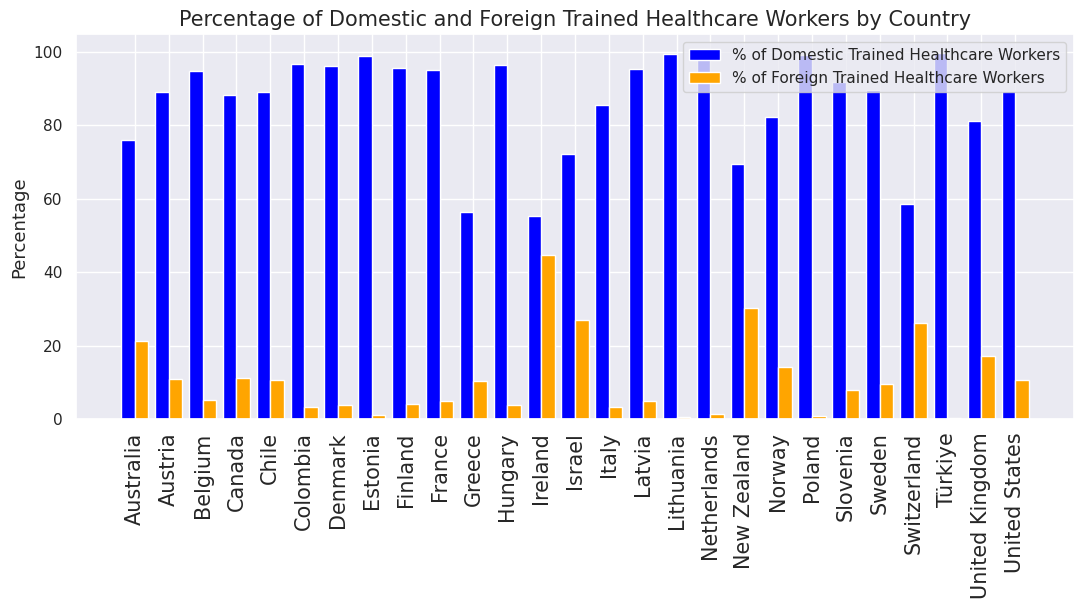

In [34]:
bar_width = 0.4

# bar positions
r1 = np.arange(len(worker_migr_to_plot['Country']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(11, 6.25))

#domestic healthcare workers
plt.bar(r1, worker_migr_to_plot['%_of_domestic_trained_healthcare_workers'], color='blue', width=bar_width, label='% of Domestic Trained Healthcare Workers')

#foreign healthcare workers
plt.bar(r2, worker_migr_to_plot['%_of_foreign_trained_healthcare_workers'], color='orange', width=bar_width, label='% of Foreign Trained Healthcare Workers')

plt.xticks([r + bar_width/2 for r in range(len(worker_migr_to_plot['Country']))], worker_migr_to_plot['Country'], rotation=90, size = 15)

plt.ylabel('Percentage', size = 13)
plt.title('Percentage of Domestic and Foreign Trained Healthcare Workers by Country', size = 15)
plt.legend()
plt.tight_layout()
plt.show()

As seen in the figure above, most countries' healthcare workforce (doctors and nurses) is predominantly local. However, some interesting patterns emerge. Ireland, Israel, New Zealand, Australia, and Switzerland stand out with over 20% of their healthcare workforce being foreign. While many factors affect these percentages, the OECD's 2015 Health Glance provides some insight; in Israel's case, many licenses are issued to doctors born domestically but who completed their training abroad. Although less prevalent, this pattern is also present in Norway, helping to explain their relatively high percentage of foreign trained health care workers. 

An interesting case study is Switzerland. Several factors appear to influence their healthcare workforce composition. Despite not being in the European Union, there is a free movement of people agreement between Switzerland and the EU. Switzerland's high quality of living and high salaries are likely appealing. This is evidenced by the large majority of these foreign-trained doctors being from neighboring countries, such as France and Italy(OFSP, 2023). Additionally, Switzerland has not trained enough doctors leading to a current shortage of domestically-educated health care professionals.

## Maps

This section contains two interactive maps: one showing total annual inflow of healthcare professionals and the other showing the percentage of foreign healthcare workers. Hover over countries on the maps to see breakdowns by profession.

In [35]:
map_data = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                        '%_of_foreign_trained_healthcare_workers', "% of foreign-trained doctors",
                        "% of foreign-trained nurses", "Foreign-trained doctors - Annual inflow",
                        "Foreign-trained nurses - Annual inflow"]].groupby('Country').mean().reset_index()

map_data["Total foreign healthcare professional annual inflow"] = map_data["Foreign-trained doctors - Annual inflow"]+map_data["Foreign-trained nurses - Annual inflow"]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world['name'] = world['name'].replace({'United States of America': 'United States', 'Turkey': 'Türkiye'}) 

merged_data = world.merge(map_data, how='left', left_on='name', right_on='Country')

/tmp/ipykernel_2050/1939353147.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [36]:
geo_source = GeoJSONDataSource(geojson=merged_data.to_json())
color_mapper = LinearColorMapper(palette=OrRd[9][::-1], low=0, high=15000)

hover = HoverTool(tooltips=[('Country', '@name'),
                            ('Total foreign healthcare professional annual inflow', '@{Total foreign healthcare professional annual inflow}{0.2f}'),
                            ('Annual inflow of foreign-trained doctors', '@{Foreign-trained doctors - Annual inflow}{0.2f}'),
                            ('Annual inflow of foreign-trained nurses', '@{Foreign-trained nurses - Annual inflow}{0.2f}')])

p = figure(title="Map of OECD Healthcare Immigration (Average Annual Inflow)", align = 'center', tools=[hover], width=1000, height=600)
p.title.align = 'center'
p.patches('xs', 'ys', source=geo_source,
          fill_color={'field': 'Total foreign healthcare professional annual inflow', 'transform': color_mapper},
          line_color='black', line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                     border_line_color=None, location='bottom_center', orientation='horizontal', 
                     title="Total foreign healthcare professional annual inflow")

footnote = Label(x=10, y=5, x_units='screen', y_units='screen',
                 text="Source: OECD (2023)", render_mode='css',
                 text_font_size='10pt', text_color='gray')

p.add_layout(footnote)
p.add_layout(color_bar, 'below')

output_notebook()
show(p)

Loading BokehJS ...

In [37]:
geo_source = GeoJSONDataSource(geojson=merged_data.to_json())
color_mapper = LinearColorMapper(palette=OrRd[9][::-1], low=0, high=45)

hover = HoverTool(tooltips=[('Country', '@name'),
                            ('% of foreign-trained healthcare workers', '@{%_of_foreign_trained_healthcare_workers}{0.2f}%'),
                            ('% of foreign-trained doctors', '@{% of foreign-trained doctors}{0.2f}%'),
                            ('% of foreign-trained nurses', '@{% of foreign-trained nurses}{0.2f}%')])

q = figure(title="Map of OECD Healthcare Immigration (% Foreign Trained)", align = 'center', tools=[hover], width=1000, height=600)
q.title.align = 'center'
q.patches('xs', 'ys', source=geo_source,
          fill_color={'field': '%_of_foreign_trained_healthcare_workers', 'transform': color_mapper},
          line_color='black', line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                     border_line_color=None, location='bottom_center', orientation='horizontal', 
                     title="% of foreign-trained healthcare workers")

footnote = Label(x=10, y=5, x_units='screen', y_units='screen',
                 text="Source: OECD (2023)", render_mode='css',
                 text_font_size='10pt', text_color='gray')

q.add_layout(footnote)
q.add_layout(color_bar, 'below')

output_notebook()
show(q)

Loading BokehJS ...

## Conclusion
Throughout this project we explored the relationship among healthcare systems and the migration of healthcare professionals in OECD countries. We started by comparing health quality (through mortality and hospital readmission rates), health status, and patient satisfaction (through percentage of the population with perceived with bad health and proportion of patients with enough consultation time) with annual inflow of foreign healthcare workers. 
The results of this analysis were mixed, as acute healthcare and foreign medical professionals had a negative relationship but patient satisfaction and health status had a positive relationship with foreign healthcare worker inflows. 

Then we explored the behavior of foreign-trained healthcare workers with respect to healthcare spending, remuneration of healthcare workers, and government insurance. The results aligned with economic theory, as greater remuneration and expenditure predicted an increase in the annual inflow and proportion of foreign trained healthcare workers. However, insurance had an insignificant relationship.

Next we displayed the proportions of domestic versus foreign trained healthcare workers, and found that the proportions are predominantly domestic, but there were some countries with considerably higher rates (Israel, Ireland, New Zealand, Australia, and Switzerland).

Lastly, we plotted interactive maps in order to visualize the distribution and magnitude of healthcare professional inflows.

Further research can focus on the impacts of migration on the countries where healthcare professionals emigrated from, and examine if the outcomes in the receiving countries differ based on the distribution of countries of origin of their immigrants. 

## References
Global Affairs Canada. (2017). Global Health and Development. Retrieved from https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?
lang=eng

OECD (2023), International Migration Outlook 2023, OECD Publishing, Paris, https://doi.org/10.1787/b0f40584-en

OECD (2023), *Demographic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR

OECD (2023), *Economic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR

OECD (2023), *Health Expenditure and Financing*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=SHA

OECD (2015), *International migration of doctors*, in Health at a Glance 2015: OECD Indicators, OECD
Publishing, Paris.

OECD (2023), *Healthcare Quality Indicators*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI

OECD (2023), *Healthcare Resources*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC

OECD (2023), *Healthcare Utilization* OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC

OECD (2023), *Social Protection*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT

OECD (2023), *Health Workforce Migration*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI

OFSP(2023), *Statistiques médecins*, https://www.bag.admin.ch/bag/fr/home/zahlen-und-statistiken/statistiken-berufe-im-gesundheitswesen/statistiken-medizinalberufe1/statistiken-aerztinnen-aerzte.html
